# **Import Library dan Deteksi Perangkat**

In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
from torch import nn
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
import time
from tqdm import tqdm
from torchvision.models import AlexNet_Weights


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# **Memuat Dataset**

In [ ]:
train_data_path = '../content/emnist-bymerge-test.csv'
val_data_path = '../content/emnist-bymerge-train.csv'


data_train = pd.read_csv(train_data_path, header=None, nrows=1500)
data_val = pd.read_csv(val_data_path, header=None, nrows=1500)
print("Dataset loaded successfully.")

Dataset loaded successfully.


# **Melakukan Preprocessing pada Gambar**

In [ ]:
def preprocess_image(data):
    data = np.clip(data, 0, 255).astype(np.uint8).reshape(28, 28)
    return Image.fromarray(data).convert("RGB")

# **Mendefinisikan Kelas Custom Dataset**

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = self.dataframe.iloc[idx, 0]
        img_data = self.dataframe.iloc[idx, 1:].values
        image = preprocess_image(img_data)
        if self.transform:
            image = self.transform(image)
        return image, label

# **Melakukan Transformasi Data untuk Gambar**

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# **Meninjau Transformasi Data**

In [ ]:
data_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

# **Mendefinisikan Model AlexNet**

In [ ]:
model = models.alexnet (weights=AlexNet_Weights.DEFAULT)
model.classifier[6] = nn.Linear(4096, 47)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# **Membekukan Parameter Ekstraktor Fitur**

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False
    print (param.requires_grad)

False
False
False
False
False
False
False
False
False
False


In [ ]:
for param in model.classifier.parameters():
    print (param.requires_grad)

True
True
True
True
True
True


# **Leave-One-Out Cross Validation (LOOCV)**

In [ ]:

data_array = data_train.to_numpy()
loo = LeaveOneOut()

all_preds, all_labels = [], []

print("Starting LOOCV...")
start_time = time.time()

for train_idx, test_idx in tqdm(loo.split(data_array)):
    train_samples = data_array[train_idx]
    test_sample = data_array[test_idx]

    train_dataset = CustomDataset(pd.DataFrame(train_samples), transform=data_transforms)
    test_dataset = CustomDataset(pd.DataFrame(test_sample), transform=data_transforms)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    model.train()
    for epoch in range(1):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_preds.append(torch.argmax(outputs, dim=1).cpu().item())
            all_labels.append(labels.cpu().item())

end_time = time.time()
print(f"Total Execution Time: {end_time - start_time:.2f} seconds")

Starting LOOCV...


1500it [1:47:00,  4.28s/it]

Total Execution Time: 6420.21 seconds


# **Evaluasi Performa Model**

In [ ]:
conf_matrix = confusion_matrix(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted')

# **Menampilkan Hasil Evaluasi Model**

In [ ]:
print("\nEvaluation Results:")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy :.4f}")
print(f"Precision: {precision :.4f}")
print(f"F1-Score: {f1 :.4f}")


Evaluation Results:
Confusion Matrix:
[[78  0  0 ...  0  0  0]
 [ 0 92  0 ...  0  0  0]
 [ 0  0 66 ...  0  0  0]
 ...
 [ 0  0  0 ...  7  0  0]
 [ 0  0  0 ...  0 33  0]
 [ 0  0  0 ...  0  0 38]]
Accuracy: 0.9953
Precision: 0.9955
F1-Score: 0.9953


# **Menampilkan Visualisasi Confusion Matrix**

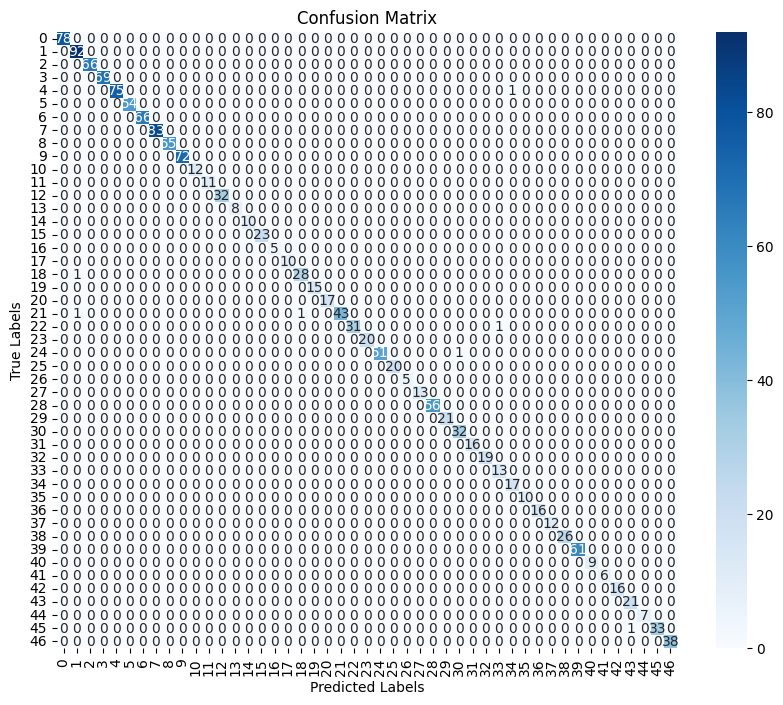

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=range(47),
            yticklabels=range(47))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()